# Project 3 - Subreddit Classification
### Matthew DeVay, ATX-DSI-11

## Problem:

Select two subreddits and from a post from either, identify which subreddit from which it originated. Evaluate at least two models, one of which must be a Naive Bayes. 

## Exectutive Summary:

After speaking with people in the general domain of Data Science, a common theme is that none of them actually consider themselves data scientists, despite almost exclusively using tools and models with which data scientists should be proficient. As such, I was curious as to whether or not the Learn Machine Learning subreddit was significantly distinguishable from the Data Science Subreddit. Anectdotally, both are casual, with representation from both newcomers and experts. There is no specified format for posting, and the subreddit rules are fairly similar. 

Data was obtained via the pushshift API, with posts tagged as removed by moderators and/or users rejected. Crossposts were set to 0 to reject submissions that may have been crossposted on both subs. Video posts were similarly rejected. Only submissions were analyzed. 

The submission title data were CountVectorized and fed into a Multinomial Naive Bayes (MNB) model. Grid search was performed over several hyperparameters. The grid search yielded a model with approximately 78% accuracy score for predicting which subreddit a post may have come from based on its title. Predictions for the validation data had an accuracy score of approximately 77%, indicating reasonable bias and variance for this model.

Further modeling was done using TF-IDF Vectorization, and used to train a support vector model. Grid search was also performed over several hyperparameters, and yielded a model with approximately 78% accuracy as well. Predictions for the validation data had an accuracy of approximately 76%, also indicating reasonable bias and variance, but failing to outperform the MNB model.

As an extra step, the gridsearch model for the MNB was trained on the selftext data. Prior to this, the selftext data had been munged to remove empty or nan observations. This leads to a roughly 20% reduction in total data, and makes predictibility dependent on the presence of selftext data. It also massively increases the features after vectorization, which leads to significantly longer modeling times. 

The accuracy score of the selftext training data for the best performing MNB model was approximately 81%. The accuracy for the validation data was approximately 82%. A 3% gain in accuracy was realized at the cost of approximately a 5x increase in CPU utilization. Combined with the lowered number of suitable submissions, predicting based on selftext probably does not provide any benefit for real-world application of the model.

In summation, it is sufficiently challenging to predict accurately whether or not a post originated in a group focused on Data Science or Machine Learning. Based on these models, my friend should acknowledge that machine learning and data science are inextricably intertwined.

## Import and EDA

In [1]:
# import the libraries I think I might need:

import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import time
import requests

from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.feature_extraction import stop_words
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC


time_stamp = round(time.time())
print(f"The timestamp for this iteration of the project is {time_stamp}.")

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The timestamp for this iteration of the project is 1587755907.


C:\Users\mdeva\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# import the data from the API. We'll use the subreddits machinelearning and datascience

# code inspired by Tim Book during open office hours


def get_comments(subreddit, n_k):
    '''This function will collect n * 1000 comments from a subreddit via the pushshift.io API, 
    starting with the most recent comments'''
    
    # instantiate a list to hold the dataframes
    df_list = []
    
    # initiate a time counter to the current time
    
    current_time = time_stamp
    # iterate for each set of 1000 comments
    for n in range(n_k):
        
        # get the data:
        res = requests.get(
            'https://api.pushshift.io/reddit/search/submission/?',
            params={
                "subreddit": subreddit,  
                "size": 1000,
                "lang": True,
                "before": current_time,
                "user_removed" : False,
                "mod_removed" : False,
                "num_crossposts" : 0,
                "is_video" : False
            }
        )
        
        # wait a few seconds to be nice to the server:
        time.sleep(2)
        
        # create a dataframe from the request JSON
        df = pd.DataFrame(res.json()['data'])
        
        # isolate the columns we need
        df = df.loc[:, ["created_utc", "title", "selftext", "subreddit"]]
        
        # add them to the list of dataframes
        df_list.append(df)
        
        # adjust the time counter to the oldest time in the dataframe
        current_time = df.created_utc.min()
    
    # return the concatenated dataframes from the list
    return pd.concat(df_list, axis=0, ignore_index=True)

In [3]:
df_ds = get_comments('datascience', 3)

In [4]:
df_ml = get_comments('learnmachinelearning', 3)

In [5]:
# concat the datascience and machinelearning dataframes:

df = pd.concat([df_ml, df_ds], axis=0, ignore_index=True)

In [6]:
df.head()

,created_utc,title,selftext,subreddit
0,1587754577,"""Machine Learning Engineering"" Learning Series...",(I hope it is appropriate to post this here)\n...,learnmachinelearning
1,1587750757,A Simple Machine Learning Project Since Data C...,,learnmachinelearning
2,1587748828,Dynamically shaped tensor in Keras,I need to create a tensor of zeros with dimens...,learnmachinelearning
3,1587748303,Why is my Ann slower than tensorflows?,I make my own multi layer perception in python...,learnmachinelearning
4,1587747370,Kaggle Mastery,"Hello, beginner in data science here. I have ...",learnmachinelearning


In [7]:
df.tail()

,created_utc,title,selftext,subreddit
5995,1582147424,Creating Model vs Using Library,I just finished a small machine learning serie...,datascience
5996,1582145831,Project related to text mining,I have enrolled into a text mining course in m...,datascience
5997,1582145687,Is it possible to become a self-taught data sc...,Has anyone else on this subreddit transitioned...,datascience
5998,1582140495,"Hey guys, I just got into Data Science, I have...",,datascience
5999,1582139304,Decent survey creator to collect answers,,datascience


In [8]:
df.shape

(6000, 4)

In [9]:
# now that our raw data is imported and ready to go, lets create a new dataframe
# from it so that we can always go back and reference the raw
# let's start by making a dummy of the target column:

data = pd.get_dummies(df, columns=['subreddit'], drop_first=True)

In [10]:
data.head()

,created_utc,title,selftext,subreddit_learnmachinelearning
0,1587754577,"""Machine Learning Engineering"" Learning Series...",(I hope it is appropriate to post this here)\n...,1
1,1587750757,A Simple Machine Learning Project Since Data C...,,1
2,1587748828,Dynamically shaped tensor in Keras,I need to create a tensor of zeros with dimens...,1
3,1587748303,Why is my Ann slower than tensorflows?,I make my own multi layer perception in python...,1
4,1587747370,Kaggle Mastery,"Hello, beginner in data science here. I have ...",1


In [11]:
# in this case, we've set up the data so that we have ml as 1 and datascience as 0.
# let's rename that column so that it is a little easier to work with

data.rename(columns={'subreddit_learnmachinelearning' : 'target'}, inplace=True)
data.head()

,created_utc,title,selftext,target
0,1587754577,"""Machine Learning Engineering"" Learning Series...",(I hope it is appropriate to post this here)\n...,1
1,1587750757,A Simple Machine Learning Project Since Data C...,,1
2,1587748828,Dynamically shaped tensor in Keras,I need to create a tensor of zeros with dimens...,1
3,1587748303,Why is my Ann slower than tensorflows?,I make my own multi layer perception in python...,1
4,1587747370,Kaggle Mastery,"Hello, beginner in data science here. I have ...",1


In [12]:
# now we can drop timestamps and for now, selftext:

data_ref = data.drop(columns=['created_utc', 'selftext'])
data_ref.head()

,title,target
0,"""Machine Learning Engineering"" Learning Series...",1
1,A Simple Machine Learning Project Since Data C...,1
2,Dynamically shaped tensor in Keras,1
3,Why is my Ann slower than tensorflows?,1
4,Kaggle Mastery,1


In [13]:
# now lets work on some visualization!

title_counts = df['title']

In [14]:
# we should at least look at the most common words
# we'll use a Count Vectorizer to do this
cvec = CountVectorizer(stop_words='english')
terms = cvec.fit_transform(title_counts)
title_count = pd.DataFrame(terms.toarray(), columns=cvec.get_feature_names())

In [15]:
title_count['sub'] = df['subreddit']

In [16]:
title_count['target'] = data['target']

In [17]:
ds_top = list(title_count.groupby('target').mean().T.sort_values(0, ascending=False).head(20).index)
ml_top = list(title_count.groupby('target').mean().T.sort_values(1, ascending=False).head(20).index)

In [18]:
ds_top

['data',
 'science',
 'learning',
 'scientist',
 'python',
 'covid',
 '19',
 'help',
 'career',
 'job',
 'machine',
 'best',
 'looking',
 'need',
 'analysis',
 'using',
 'time',
 'learn',
 'analytics',
 'advice']

In [19]:
ds_top_cnt = list(title_count[title_count["target"] == 0][ds_top].sum().sort_values(ascending=False))
ds_top_cnt

[1450,
 747,
 172,
 151,
 149,
 129,
 128,
 120,
 97,
 97,
 92,
 88,
 86,
 86,
 84,
 82,
 79,
 78,
 78,
 77]

Text(0.5, 1.0, 'Top words in r/datascience Titles')

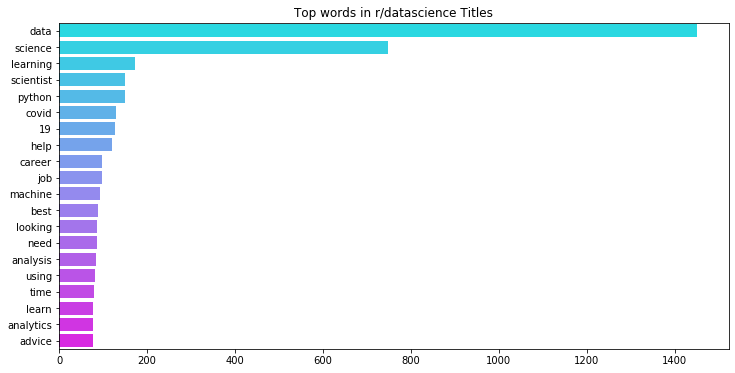

In [20]:
plt.figure(figsize=(12,6))
sns.barplot(y=ds_top, x=ds_top_cnt, orient='h', palette='cool')
plt.title('Top words in r/datascience Titles')

Text(0.5, 1.0, 'Top words in r/learnmachinelearning Titles')

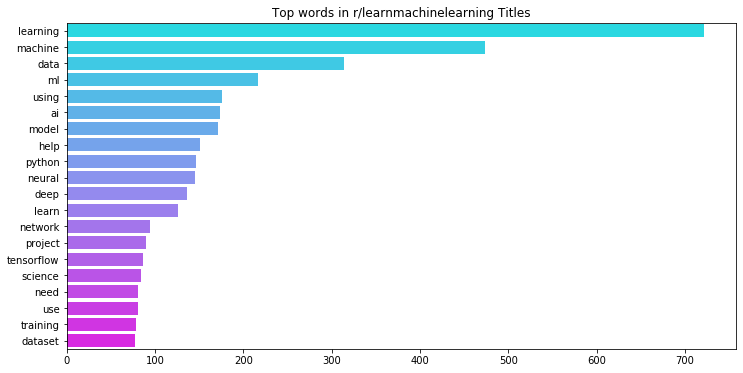

In [21]:
ml_top_counts = list(title_count[title_count["target"] == 1][ml_top].sum().sort_values(ascending=False))
plt.figure(figsize=(12,6))
sns.barplot(y=ml_top, x=ml_top_counts, orient='h', palette='cool')
plt.title('Top words in r/learnmachinelearning Titles')

In [22]:
# overlap
overlap = [word for word in ml_top if word in ds_top]
overlap

['learning',
 'machine',
 'data',
 'using',
 'help',
 'python',
 'learn',
 'science',
 'need']

In [23]:
overlap_df = title_count[overlap]
overlap_df['target'] = title_count['target']
overlap_count_ds = list(overlap_df[overlap_df['target']==0][overlap].sum())
overlap_count_ml = list(overlap_df[overlap_df['target']==1][overlap].sum())
ds_overlap = pd.DataFrame({
    'word' : overlap,
    'count' : overlap_count_ds
})
ds_overlap['Subreddit'] = 'r/datascience'
ds_overlap
ml_overlap = pd.DataFrame({
    'word' : overlap,
    'count' : overlap_count_ml
})
ml_overlap['Subreddit'] = 'r/learnmachinelearning'
overlap_all = pd.concat([ds_overlap, ml_overlap])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Top words for Both Subreddits Titles')

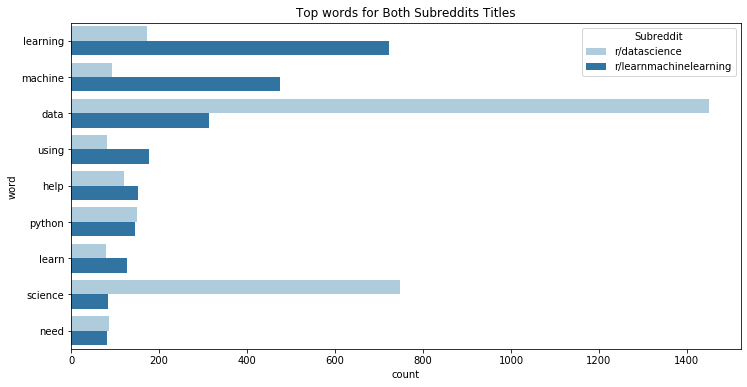

In [24]:
plt.figure(figsize=(12,6))
sns.barplot(x='count', y='word', hue='Subreddit', data=overlap_all, orient='h', palette='Paired')
plt.title('Top words for Both Subreddits Titles')

### EDA summary

As we can see, there are a lot of shared top words between each subreddit. This will likely make it challenging for our models to differentiate the two subs. However, adding them to the stopwords would be giving an unfair advantage to my friend. 

## Modeling

We'll begin with the Multinomial Naive Bayes, and also include a Gaussian Naive Bayes and a Support Vector machine:

In [25]:
# because we had the opportunity to choose the data ourselves, we have 
# perfectly balanced classes. Therefore, we won't bother to stratify 
# the training/testing sets. Let's start modeling by setting up a 
# pipeline that will use a CountVectorizer and a Multinomial Naive Bayes model

# first, we need to make a dense Transformer since we want to pass dense arrays.
# fortunately, we did this in the local lesson, and the following class definition comes
# from the Vectorizers_pipelines lesson adapted from Mahdi and BoomL

class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, y=None, **fit_params):
        return X.toarray()


pipe_mnb = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

ds_stop_words = ['data', 'science']
ml_stop_words = ['machine', 'learning']
all_stop = ds_stop_words + ml_stop_words

pipe_params = {
    'cvec__ngram_range' : [(1,1), (1,2), (1,3)], 
    'cvec__min_df' : [1, 2, 4, 10],
    'cvec__max_df' : [0.5, 0.75, 0.95, 1],
    'cvec__stop_words' : [None, 'english'],
    'cvec__max_features' : [5_000, 7_500, 10_000],
    'mnb__alpha' : [.1, 1, 10]
}



In [26]:
# now let's set up our data:

X = data_ref['title']
y = data_ref['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)



In [27]:
# now we can fit and score our pipeline:
gs_mnb = GridSearchCV(
    pipe_mnb,
    param_grid=pipe_params,
    cv=5,
    n_jobs=-1,
    verbose=1
)

%time
gs_mnb.fit(X_train, y_train)

Wall time: 0 ns
Fitting 5 folds for each of 864 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 4289 out of 4320 | elapsed:  1.0min remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed:  1.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [28]:
gs_mnb.best_estimator_

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.5,
                                 max_features=5000, min_df=2,
                                 ngram_range=(1, 3), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('mnb',
                 MultinomialNB(alpha=10, class_prior=None, fit_prior=True))],
         verbose=False)

In [29]:
model_list = ['MNB']
score_list = [gs_mnb.best_score_]
data_list = ['Training']

gs_mnb.best_score_

0.784

In [30]:
# as you can see, the best NB model we created can only distinguish the 
# machinelearning and datascience subreddits about 78% of the time

In [31]:
model_list.append('MNB')
score_list.append(gs_mnb.score(X_test, y_test))
data_list.append('Testing')
gs_mnb.score(X_test, y_test)

0.7706666666666667

In [32]:
# lets see if we can improve that with a TFIDF/GaussianNB:

pipe_gnb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('_', DenseTransformer()),
    ('gnb', GaussianNB())
])

pipe_params = {
    'tfidf__ngram_range' : [(1, 1), (1, 2), (1, 3)], 
    'tfidf__min_df' : [1, 2, 4, 10],
    'tfidf__max_df' : [0.5, 0.75, 0.95, 1],
    'tfidf__stop_words' : [None, 'english'],
    'tfidf__max_features' : [1_000, 2_000, 3_000],
}


In [33]:
gs_gnb = GridSearchCV(pipe_gnb,
                     pipe_params,
                     cv=5,
                     n_jobs=-1,
                     verbose=True,
)

%time
gs_gnb.fit(X_train, y_train)

Wall time: 0 ns
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   55.6s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [34]:

gs_gnb.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.5, max_features=1000,
                                 min_df=10, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('_', <__main__.DenseTransformer object at 0x000001E6926AC488>),
                ('gnb', GaussianNB(priors=None, var_smoothing=1e-09))],
         verbose=

In [35]:
model_list.append('GNB')
score_list.append(gs_gnb.best_score_)
data_list.append("Training")
gs_gnb.best_score_

0.7226666666666667

In [36]:
gs_mnb.best_score_

0.784

In [37]:
model_list.append('GNB')
score_list.append(gs_gnb.score(X_test, y_test))
data_list.append("Testing")
gs_gnb.score(X_test, y_test)

0.7066666666666667

In [38]:
gs_mnb.score(X_test, y_test)

0.7706666666666667

In [39]:
# so for now, the countvectorizer/multinomial NB takes the crown. Our GNB is probably a little 
# overfit, so we could go back and change the parameters, but I strongly doubt that we'll
# get much better than the MNB version.
# lets try a support vector machine next:

pipe_svc_tfidf = Pipeline([
    ('vect',  TfidfVectorizer()),
    ('est', SVC())
])

pipe_params = {
    'vect' : [TfidfVectorizer()],
    'vect__ngram_range' : [(1, 2), (1, 3)], 
    'vect__stop_words' : [None, 'english'],
    'vect__min_df' : [1, 5],
    'vect__max_df' : [0.75, 0.9, 1],
    'vect__max_features' : [2_000, 4_000, 6_000],
    'est__C' : [0.1, 1, 10],
}



In [40]:
gs_svc_tfidf = GridSearchCV(
    pipe_svc_tfidf,
    pipe_params,
    cv=5,
    n_jobs=-1,
    verbose=1
)

%time
gs_svc_tfidf.fit(X_train, y_train)

Wall time: 0 ns
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  1.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [41]:
model_list.append('SVC')
score_list.append(gs_svc_tfidf.best_score_)
data_list.append("Training")
gs_svc_tfidf.best_score_

0.7824444444444444

In [42]:
gs_svc_tfidf.best_estimator_

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.75, max_features=6000,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('est',
                 SVC(C=1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', 

In [43]:
model_list.append('SVC')
score_list.append(gs_svc_tfidf.score(X_test, y_test))
data_list.append("Testing")
gs_svc_tfidf.score(X_test, y_test)

0.7653333333333333

In [44]:
# So 78%/78%, comparable to the MNB model earlier.
# Well now we have two working pipelines and gridsearches (svc with tfidf and MNB), maybe we'll
# have better luck using the self text instead

# first, lets check for nans:

data.isnull().sum()


created_utc     0
title           0
selftext       35
target          0
dtype: int64

In [45]:
# 35 out of 6k. Easy enough to drop them.

df_text = data.dropna(axis = 0)
df_text.head()

,created_utc,title,selftext,target
0,1587754577,"""Machine Learning Engineering"" Learning Series...",(I hope it is appropriate to post this here)\n...,1
1,1587750757,A Simple Machine Learning Project Since Data C...,,1
2,1587748828,Dynamically shaped tensor in Keras,I need to create a tensor of zeros with dimens...,1
3,1587748303,Why is my Ann slower than tensorflows?,I make my own multi layer perception in python...,1
4,1587747370,Kaggle Mastery,"Hello, beginner in data science here. I have ...",1


In [46]:
# now lets see how many blank messages there are:
mask = df_text['selftext'] != ''
df_text_munged = df_text[mask]
df_text_munged.head()

,created_utc,title,selftext,target
0,1587754577,"""Machine Learning Engineering"" Learning Series...",(I hope it is appropriate to post this here)\n...,1
2,1587748828,Dynamically shaped tensor in Keras,I need to create a tensor of zeros with dimens...,1
3,1587748303,Why is my Ann slower than tensorflows?,I make my own multi layer perception in python...,1
4,1587747370,Kaggle Mastery,"Hello, beginner in data science here. I have ...",1
5,1587747273,CNN for color classification,This is my first CNN and right now can only ha...,1


In [47]:
df_text_munged.shape


(4449, 4)

In [48]:
df_text_munged['target'].mean()

0.48482805124747136

In [49]:
# so classes are still fairly balanced, even with munging. Let's set up X and y
# we can try our already created GridSearches to optimize

X = df_text_munged['selftext']
y = df_text_munged['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [50]:
import copy

gs_mnb_text = copy.deepcopy(gs_mnb)
gs_mnb_text.fit(X_train, y_train)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed:  8.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [51]:
model_list.append('MNB - selftext')
score_list.append(gs_mnb_text.best_score_)
data_list.append('Training')
gs_mnb_text.best_score_

0.8189439711282084

In [52]:
model_list.append('MNB - selftext')
score_list.append(gs_mnb_text.score(X_test, y_test))
data_list.append('Testing')

gs_mnb_text.score(X_test, y_test)

0.8005390835579514

In [53]:
scores = {'Model' : model_list,
         'Score' : score_list,
         'Data' : data_list}

scores_df = pd.DataFrame(scores)
scores_df

,Model,Score,Data
0,MNB,0.784000,Training
1,MNB,0.770667,Testing
2,GNB,0.722667,Training
3,GNB,0.706667,Testing
4,SVC,0.782444,Training
5,SVC,0.765333,Testing
6,MNB - selftext,0.818944,Training
7,MNB - selftext,0.800539,Testing


Text(0.5, 1.0, 'Model Scores by Type')

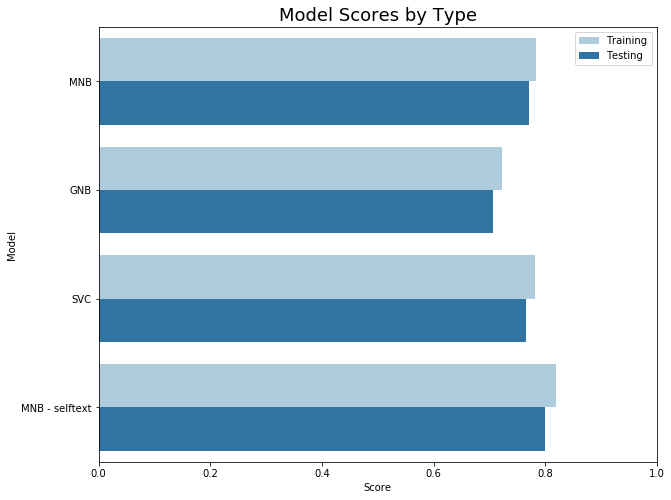

In [54]:
plt.figure(figsize=(10,8))
sns.barplot(data=scores_df, x='Score', y='Model', hue='Data', orient='h', palette='Paired')
plt.legend(loc='upper right')
plt.xlim(0, 1)
plt.title("Model Scores by Type", fontsize=18)

## Statistical Analysis

Let's take a look at some classification metrics for our best model, the MNB model based on title text:

In [62]:
from sklearn.metrics import confusion_matrix

y_preds = gs_mnb.predict(X_test)

mnb_conmatrix = confusion_matrix(y_test, y_preds)
mnb_confusion_df = pd.DataFrame(mnb_conmatrix, index=['actual ds', 'actual ml'],
            columns=['pred ds', 'pred ml'])
mnb_confusion_df

,pred ds,pred ml
actual ds,496,77
actual ml,117,423


In [67]:
def get_metrics(tp, tn, fp, fn):
    '''Get confusion matrix based classification metrics
        
        
    Keyword Arguments:
    
    tp = True Positives (pred 1 AND actual 1)
    tn = True Negatives (pred 0 AND actual 0)
    fp = False positives (pred 1 AND actual 0)
    fn = False Negatives (Pred 0 AND actual 1)
    
    Returns:
    Text Block with:
        Recall/Sensitivity/True Positive Rate
        Specificity/True Negative Rate
        Precision/Positive Predictive Value
        Negative Predictive Value
        Miss Rate/False Negative Rate
        Fall Out/False Positive Rate
        
    Output:
        Recall
        Specificity
        Precision
        
    
    '''
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    ppr = tp / (tp + fp)
    npv = tn / (tn + fn)
    fnr = 1 - tpr
    fpr = 1 - tnr

    print(f"The Sensitivity is:  {tpr}.")
    print(f"The Specificity is:  {tnr}.")
    print(f"The Precision is:    {ppr}.")
    print(f"The Neg Pred Val is: {npv}.")
    print(f"The Miss Rate is:    {fnr}.")
    print(f"The Fall Out is:     {fpr}.")
    
    return tpr, tnr, ppr

In [69]:
get_metrics(423, 496, 77, 117)

The Sensitivity is:  0.7833333333333333.
The Specificity is:  0.8656195462478184.
The Precision is:    0.846.
The Neg Pred Val is: 0.8091353996737357.
The Miss Rate is:    0.21666666666666667.
The Fall Out is:     0.13438045375218155.


(0.7833333333333333, 0.8656195462478184, 0.846)

In [ ]:
# some interesting things about the model: 
# it is more likely to mischategorize a machine learning post as a data science post
# the model is better at discriminating data science posts

## Conclusion

At approximately 80% accuracy, modeling is insufficient to fully differentiate r/learnmachinelearning and r/datascience. The model was more likely to call a r/learnmachinelearning submission as belonging to r/datascience than vice-versa. This suggests significant content overlap between the two subreddits, despite the somewhat different scopes of the subs. That the model was able to disciminate either class as well as it did suggests significant topical difference. Filtering on this basis may be a future extension of this project, depending on whether or not my friend agrees with me. For instance, removing subsets of post types such as career advice from the r/datascience group may be able to reframe the argument slightly. The question then becomes "can the technical content from r/datascience be discriminated from r/learnmachinelearning?" I feel this question is a little more to the heart of the argument with my friend, so I'll hold on to it if I need it ;-).